In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

environments = ['HalfCheetah-v5', 'Swimmer-v5', 'Walker2d-v5', 'Hopper-v5', 'Ant-v5'] #['HalfCheetah-v5', 'Hopper-v5', 'Swimmer-v5', 'Ant-v5', 'Walker2d-v5']
discount_factors = {
    'HalfCheetah-v5': 0.98,
    'Hopper-v5': 0.99,
    'Swimmer-v5': 0.9999,
    'Ant-v5': 0.99,
    'Walker2d-v5': 0.99,
    'ALE/BeamRider-v5': 0.99,
    'ALE/MsPacman-v5': 0.99,
    'ALE/Enduro-v5': 0.99
}
feedback_dir = "feedback_regen"

## Plots for evaluative feedback

In [11]:
# Compute statistics env per env (due to memory constraints)
results = {}
plot_data = {}

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for env in environments:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    feedback_files = [f for f in os.listdir(feedback_dir) if env_name in f]

    # Load data
    for file in feedback_files:
        seed = file.split('.')[0].split('_')[-1]
        with open(f"{feedback_dir}/{file}", 'rb') as f:
            data = pkl.load(f)
            plot_data[env] = data
            if env not in results:
                results[env] = []
            
            # compute discounted sum of rewards
            index = np.argsort([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])
            #index = np.arange(len([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]]))
            ordered_gt_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["segments"]])[index]

            # opt gaps
            opt_gaps = -np.array([d for d in data["opt_gaps"]])[index]

            # ratings
            ratings = np.array([d for d in data["ratings"]])[index]

            # demo rewards
            ordered_demo_rews = np.array([discounted_sum_numpy([e[2] for e in d], discount_factors[env]) for d in data["demos"]])[index]

            # store data
            results[env].append((ordered_gt_rews, opt_gaps, ratings, ordered_demo_rews))

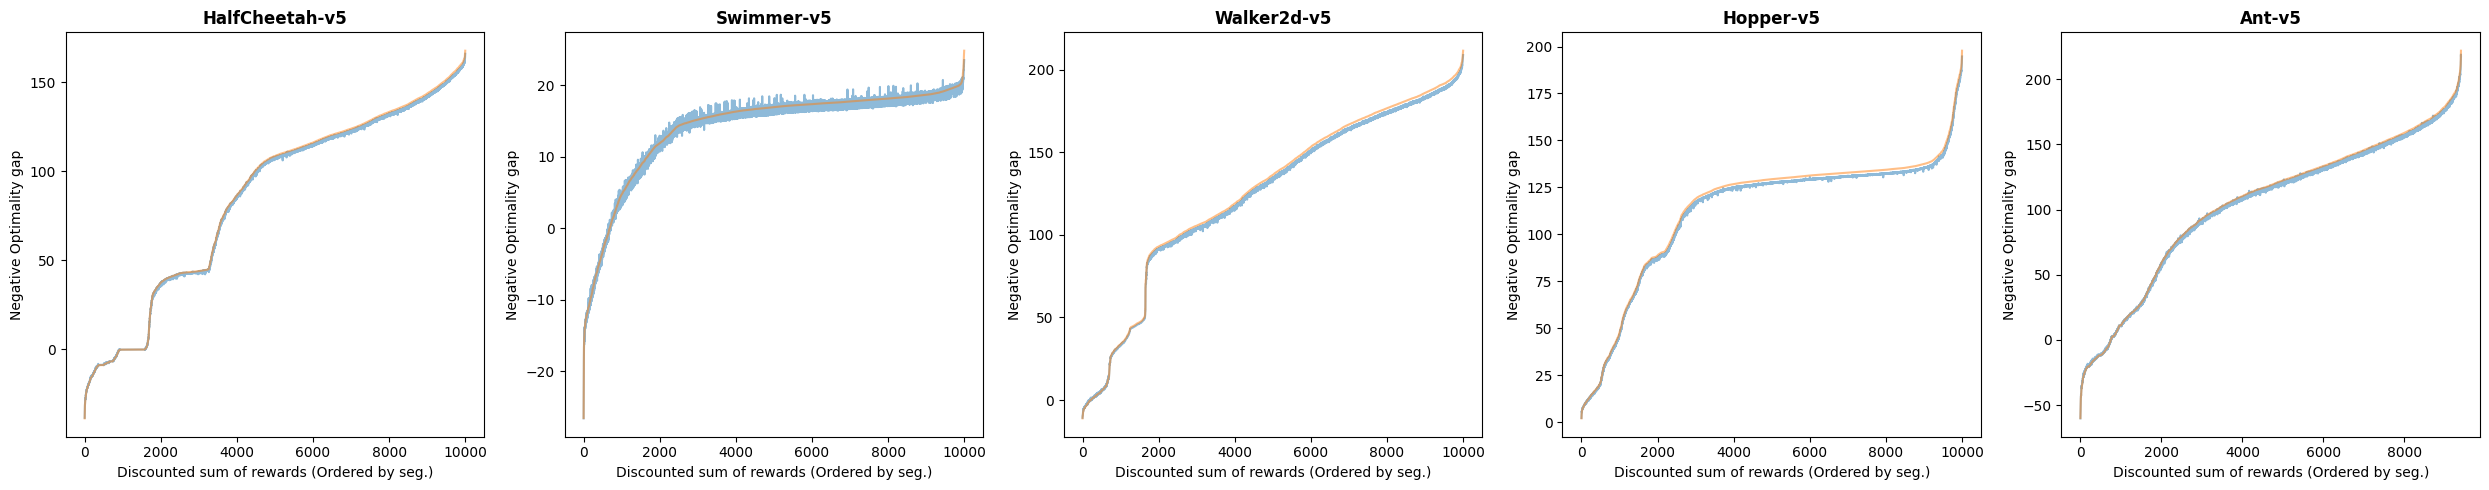

In [12]:
# make grid plot showing opt_gaps (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env][:1]:
        ax.plot(data[1], alpha=0.5)
        ax.plot(data[0], alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Discounted sum of rewards (Ordered by seg.)")
    ax.set_ylabel("Negative Optimality gap")

plt.tight_layout()

plt.savefig("opt_gaps_vs_discounted_sum_of_rewards.png")

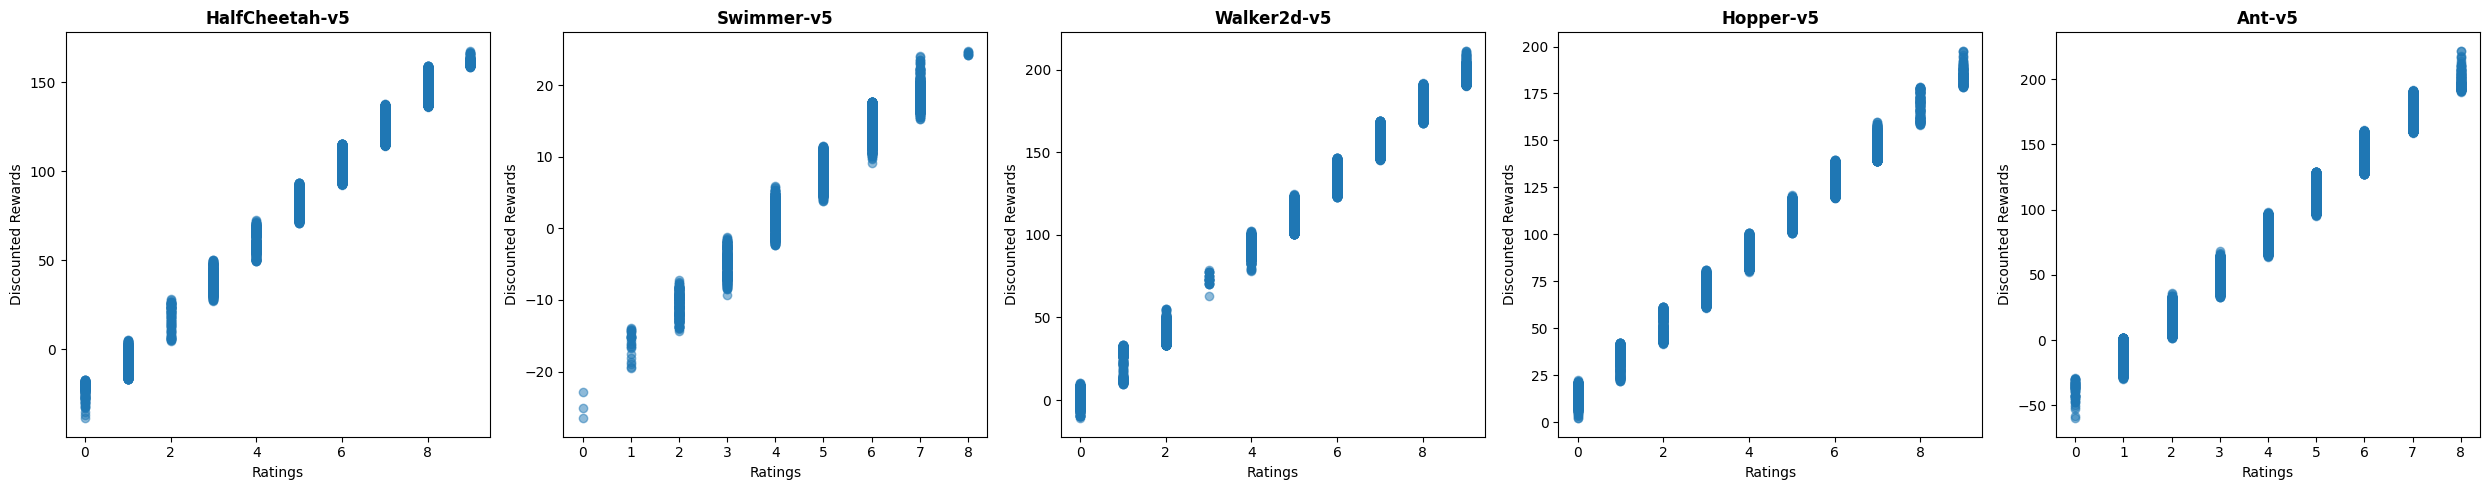

In [13]:
# make grid plot showing opt_gaps (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env][:1]:
        ax.scatter(data[2], data[0], alpha=0.5)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Ratings")
    ax.set_ylabel("Discounted Rewards")

plt.tight_layout()

plt.savefig("opt_gaps_vs_discounted_sum_of_rewards.png")

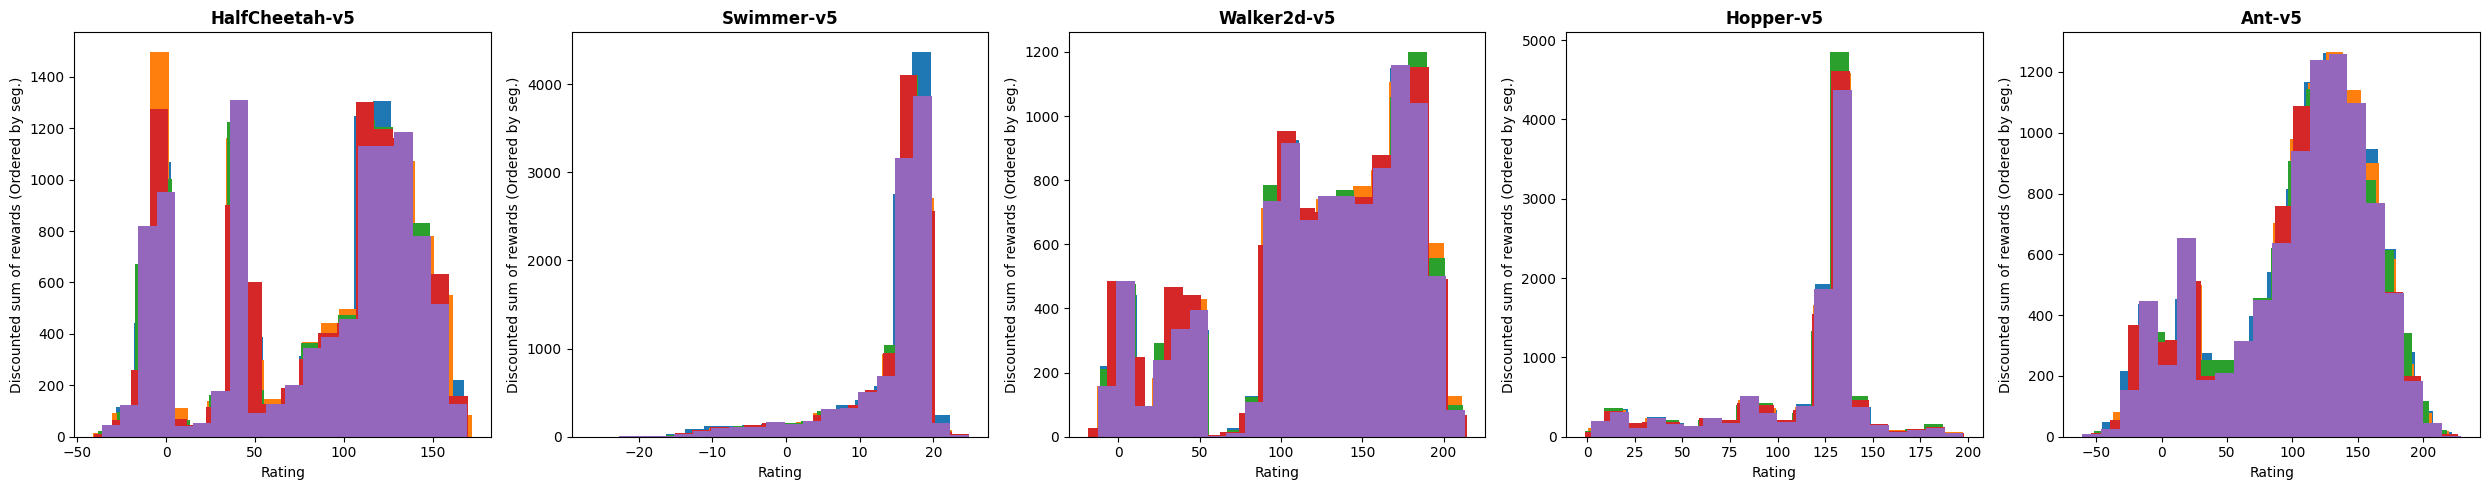

In [14]:
# make grid plot showing ratings (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env]:
        ax.hist(data[0], bins=20)
        #ax.hist(data[2], bins=20)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Rating")
    ax.set_ylabel("Discounted sum of rewards (Ordered by seg.)")

plt.tight_layout()

plt.savefig("ratings_vs_discounted_sum_of_rewards.png")

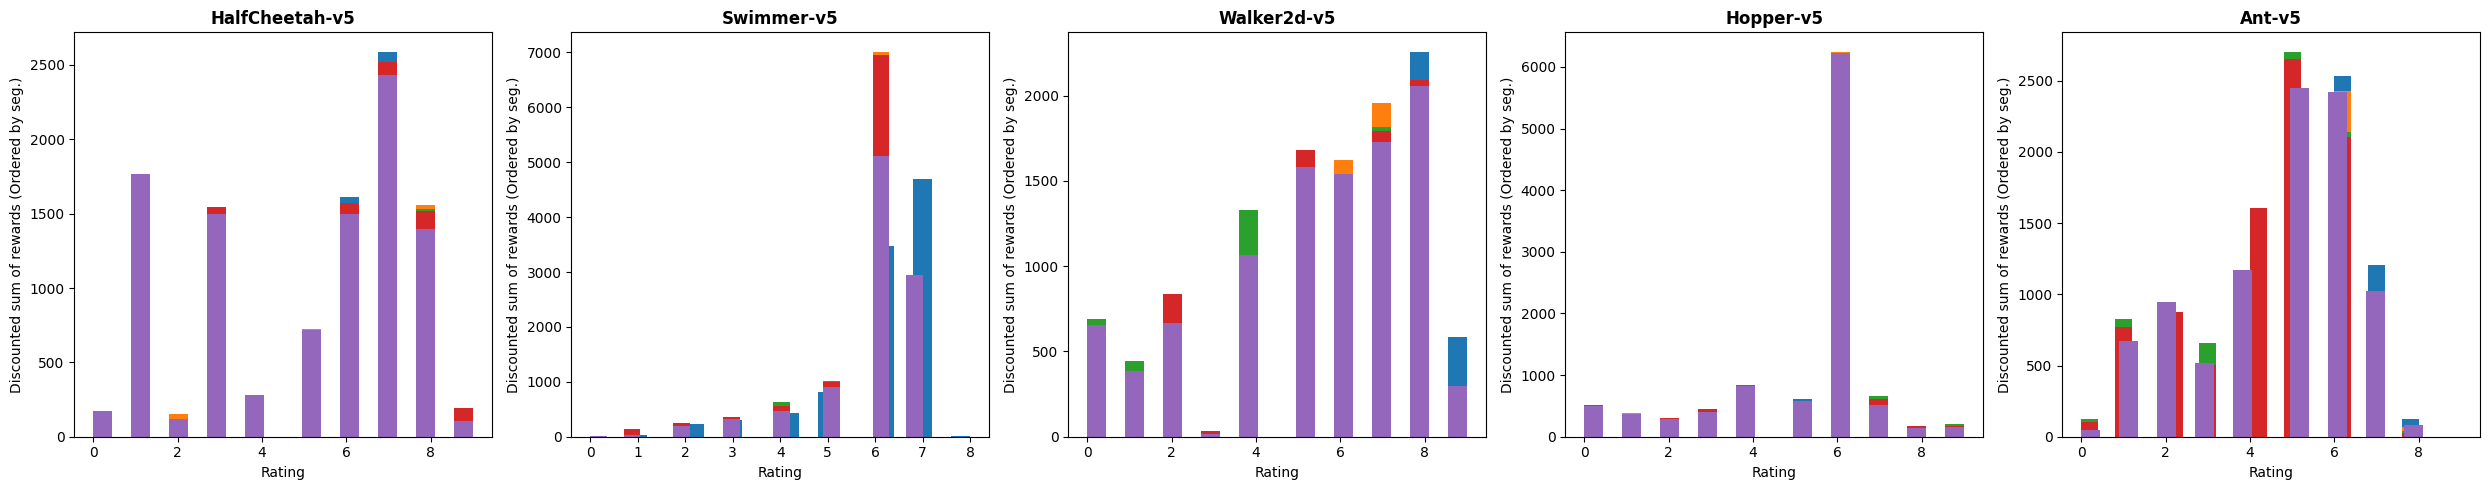

In [15]:
# make grid plot showing ratings (y-axis) vs. discounted sum of rewards (x-axis) for each environment

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, env in enumerate(environments):
    ax = axs[i % 5]
    for data in results[env]:
        ax.hist(data[2], bins=20)
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Rating")
    ax.set_ylabel("Discounted sum of rewards (Ordered by seg.)")

plt.tight_layout()

plt.savefig("ratings_vs_discounted_sum_of_rewards.png")

10000
10000
10000
10000
10000


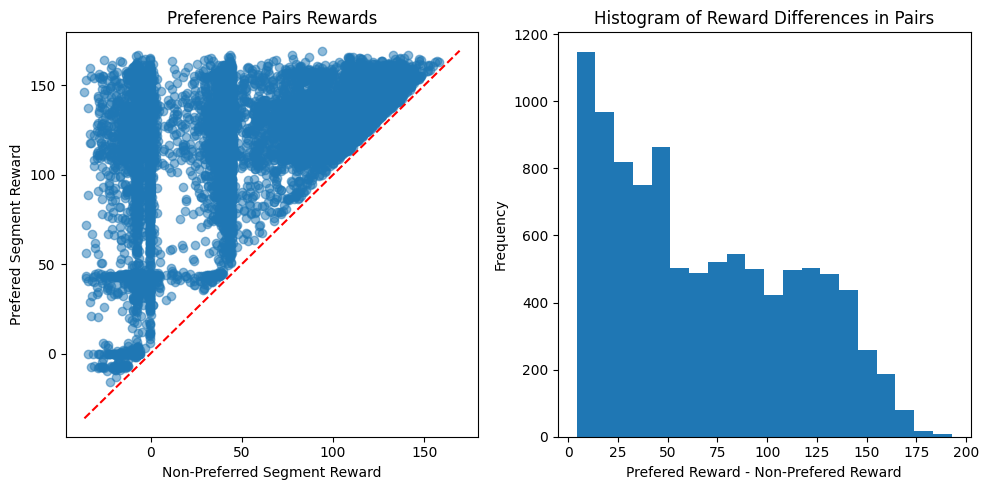

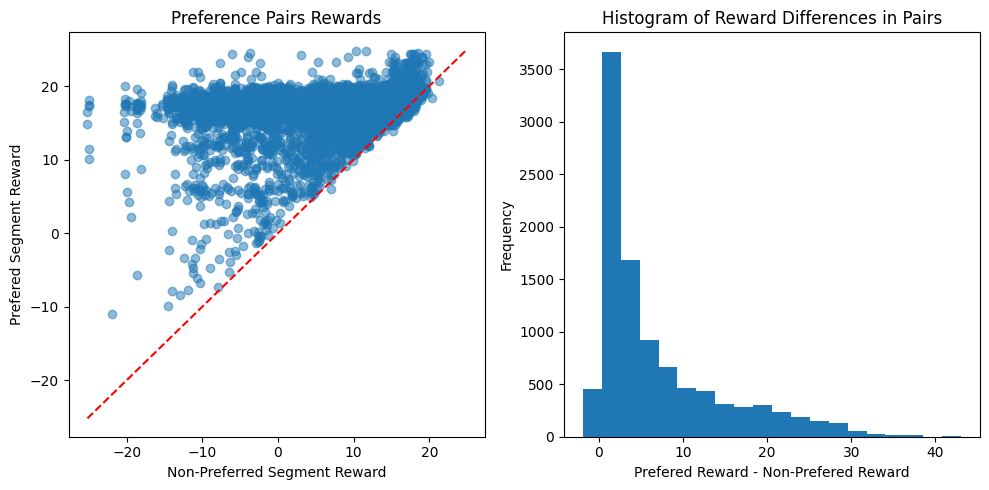

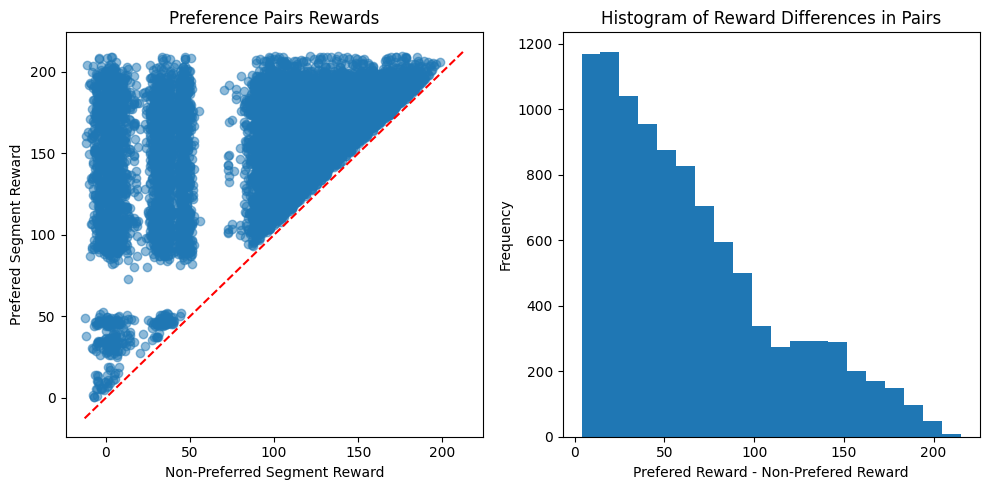

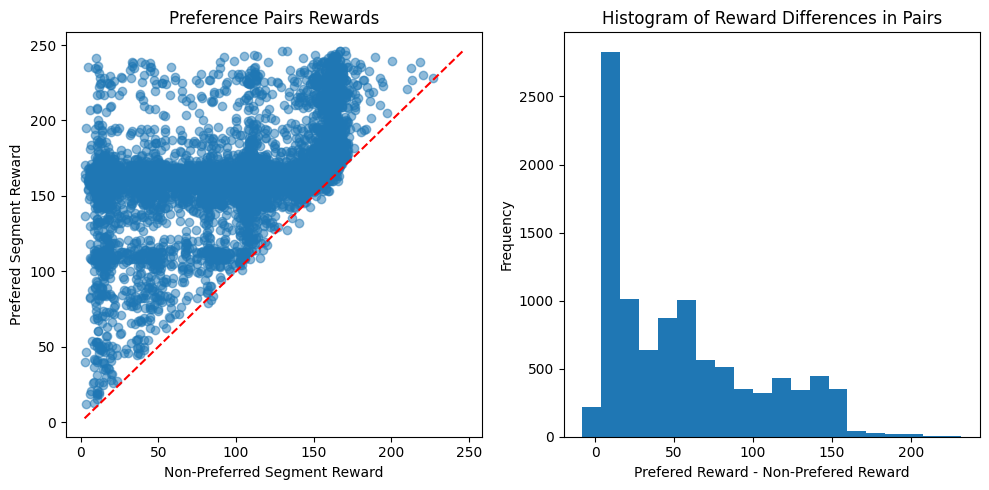

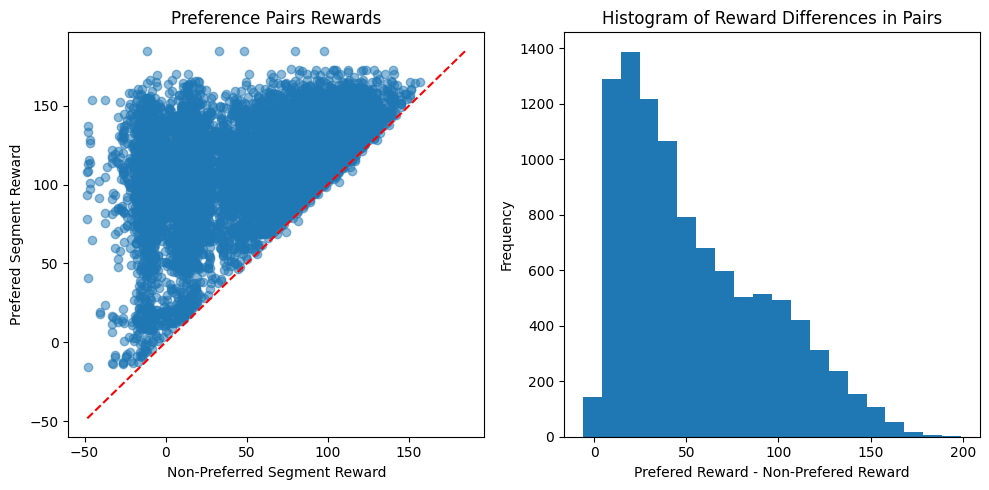

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# helper function
def discounted_sum_numpy(rewards, discount_factor):
    rewards = np.array(rewards)
    n = len(rewards)
    discount_factors = discount_factor ** np.arange(n)
    return np.sum(rewards * discount_factors)

for i, env in enumerate(environments):

    env_plot_data = plot_data[env]
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    
    # Compute discounted rewards for segments
    segment_rewards = np.array([discounted_sum_numpy([e[2] for e in seg], discount_factors[env]) for seg in env_plot_data["segments"]])

    # 1. Preference Pairs Visualization
    plt.figure(figsize=(10, 5))

    # Extract pairs and their rewards
    pair_indices = np.array(env_plot_data["preferences"])
    print(len(pair_indices))
    pair_rewards = segment_rewards[pair_indices]

    # Scatter plot of pair rewards
    plt.subplot(121)
    plt.scatter(pair_rewards[:, 0], pair_rewards[:, 1], alpha=0.5)
    plt.plot([min(segment_rewards), max(segment_rewards)], [min(segment_rewards), max(segment_rewards)], 'r--')
    plt.xlabel("Non-Preferred Segment Reward")
    plt.ylabel("Prefered Segment Reward")
    plt.title("Preference Pairs Rewards")

    # Histogram of reward differences in pairs
    plt.subplot(122)
    pair_differences = pair_rewards[:, 1] - pair_rewards[:, 0]
    plt.hist(pair_differences, bins=20)
    plt.xlabel("Prefered Reward - Non-Prefered Reward")
    plt.ylabel("Frequency")
    plt.title("Histogram of Reward Differences in Pairs")

    plt.tight_layout()
    plt.savefig(f"{env_name}_preference_pairs_analysis.png")

## Plots for demonstrative feedback

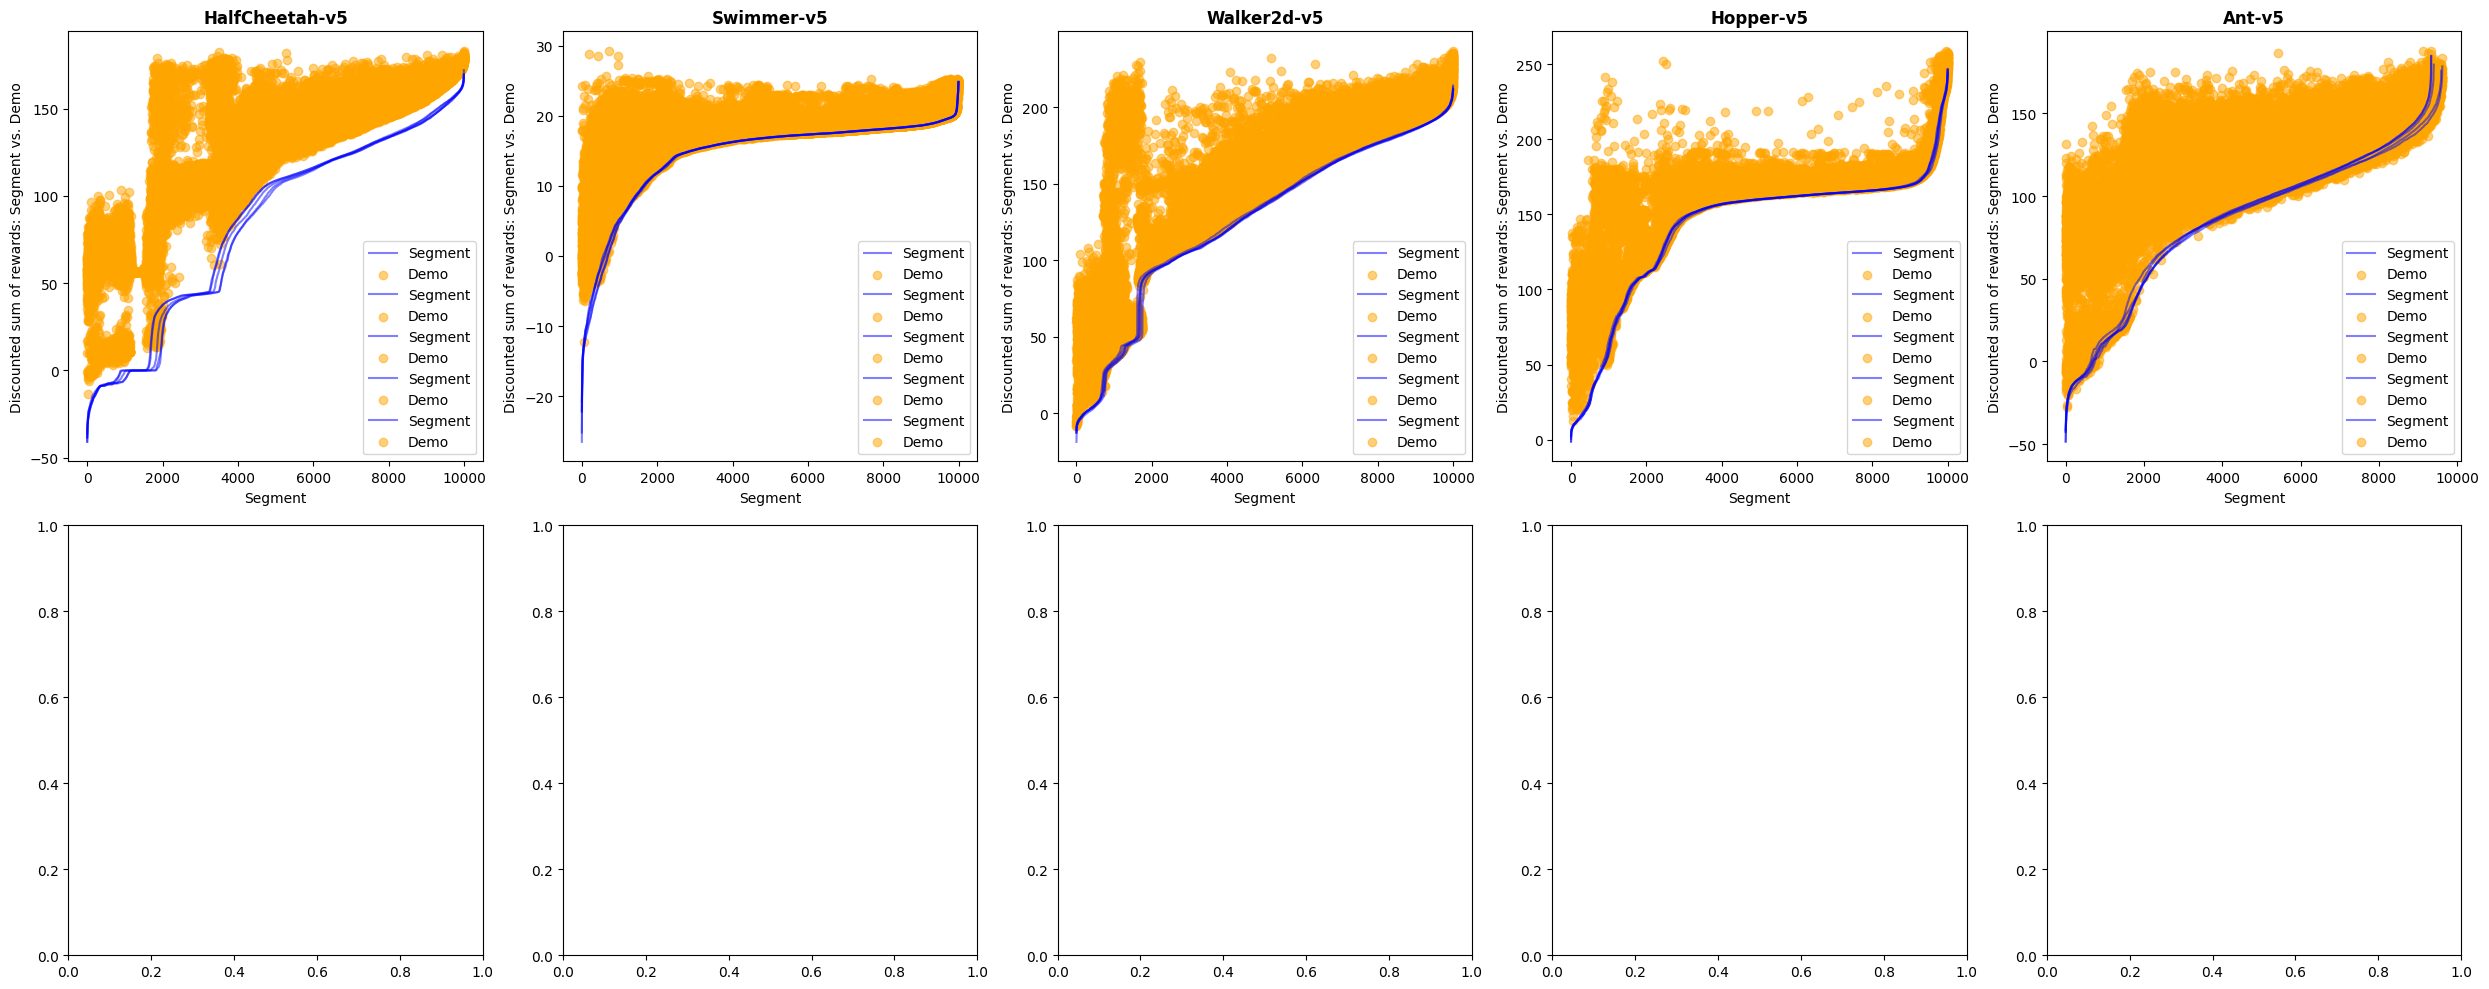

In [9]:
# Instead of ratings, we now want to compare the total rewards between original data ("segments") and demonstrations ("demos").
# make grid plot showing the total rewards for each segment and demo

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, env in enumerate(environments):
    ax = axs[i // 5, i % 5]
    for data in results[env]:
        steps = np.arange(len(data[0]))
        ax.plot(steps, data[0], label="Segment", alpha=0.5, color='blue')
        ax.scatter(steps, data[3], label="Demo", alpha=0.5, color='orange')
    ax.set_title(env, fontweight='bold')
    ax.set_xlabel("Segment")
    ax.set_ylabel("Discounted sum of rewards: Segment vs. Demo")
    ax.legend()

plt.tight_layout()

plt.savefig("segment_vs_demo_rewards.png")

In [9]:
# In the feedback_video directory, we have some selected segments. The videos are named according to the scheme "segment_env_seed_segmentindex_optgap.mp4" or "demo_env_seed_segmentindex_optgap.mp4".
# We want to create a plot showing some presentative frames (5 for each video) of the segments and demos (Here ther demos are the corrections). It's fine to just take one seed for each environment.
# Ideally, we want a grid of 5 columns and 2 rows for each environment (one row for the segments and one for the demos). And then save a plot for each environment.

import cv2
os.makedirs("correction_frames", exist_ok=True)

for env in ["Ant-v5", "HalfCheetah-v5", "Walker2d-v5"]:

    # get all feedback files matching the environment (they contain the name and the seed)
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    # get all video files matching the environment and seed
    video_files = [f for f in os.listdir("feedback_videos") if env_name in f and "segment" in f and "mp4" in f]
    demo_files = [f for f in os.listdir("feedback_videos") if env_name in f and "demo" in f and "mp4" in f]

    # we want to find the pair of segment and demo videos that have the same segment index but the highest difference in optgap
    opt_gap_diffs = []
    for file in video_files:
        _, _, _, seed, segindex, optgap = file.split('.')[0].split('_')
        
        # find the corresponding demo video (remember the optgap can be different)
        for video in demo_files:
            if segindex in video:
                _, _, _, seed, segindex, optgap_demo = video.split('.')[0].split('_')
                opt_gap_diffs.append((segindex, file, video, float(optgap)-float(optgap_demo)))
                break

    # sort by the difference in optgap
    opt_gap_diffs = sorted(opt_gap_diffs, key=lambda x: x[2], reverse=True)
    print(opt_gap_diffs)
    
    video_file = opt_gap_diffs[-1][1] #"segment_ppo_HalfCheetah-v5_1337_14_-12.mp4" #opt_gap_diffs[index][0]
    demo_file = opt_gap_diffs[-1][2] #"demo_ppo_HalfCheetah-v5_1337_14_-80.mp4" #opt_gap_diffs[index][1]
    
    cap_seg = cv2.VideoCapture(f"feedback_videos/{video_file}")
    frames_seg = []
    for i in range(5):
        cap_seg.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap_seg.read()
        if ret:
            frames_seg.append(frame)
    cap_seg.release()
    
    cap_demo = cv2.VideoCapture(f"feedback_videos/{demo_file}")
    frames_demo = []
    for i in range(5):
        cap_demo.set(cv2.CAP_PROP_POS_FRAMES, i * 10)
        ret, frame = cap_demo.read()
        if ret:
            frames_demo.append(frame)
    cap_demo.release()

    # plot into a single figure with two rows (title for each row: "Segments" and "Demos")
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    for i, frame in enumerate(frames_seg):
        axs[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[0, i].axis('off')

    for i, frame in enumerate(frames_demo):
        axs[1, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(f"correction_frames/{env_name}_{seed}_frames.png")
    plt.close()

ModuleNotFoundError: No module named 'cv2'

## Plots for Descriptive feedback

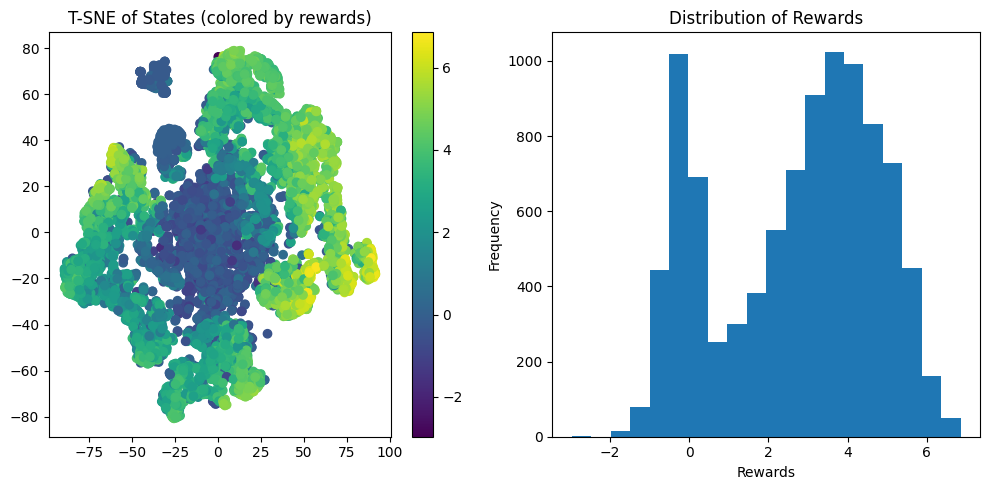

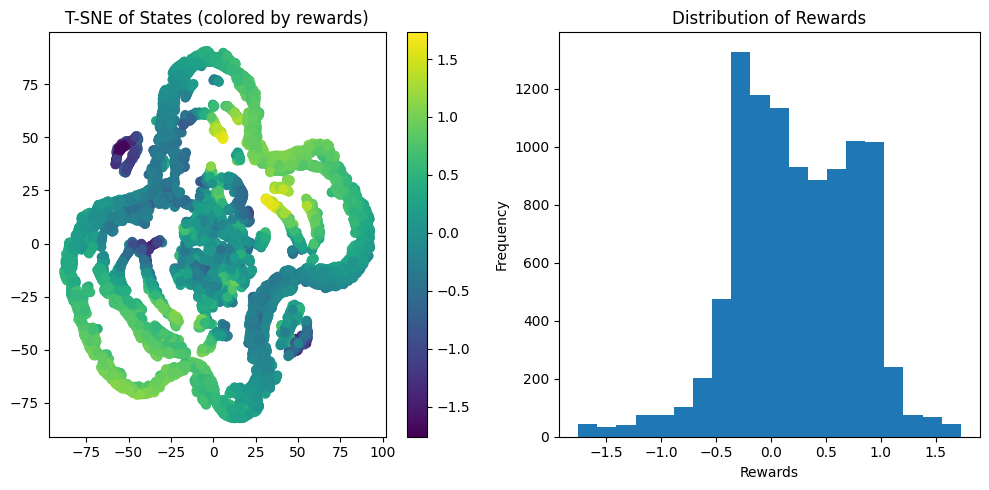

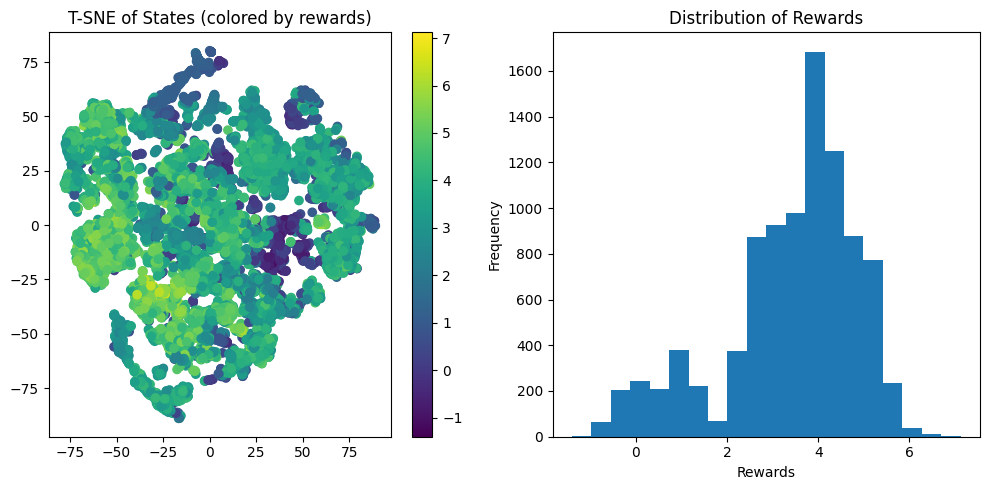

In [15]:
from sklearn.manifold import TSNE

for i, env in enumerate(environments):

    env_name = env if 'ALE' not in env else env.replace('/', '-')
    env_plot_data = plot_data[env]

    # Helper function
    # 2. Descriptive Feedback Visualization
    plt.figure(figsize=(10, 5))

    # Extract states and rewards from cluster descriptions
    states = np.array([desc[0] for desc in env_plot_data["description"]])
    rewards = np.array([desc[2] for desc in env_plot_data["description"]])

    # T-SNE visualization
    tsne = TSNE(n_components=2, random_state=42)
    states_2d = tsne.fit_transform(states)

    plt.subplot(121)
    scatter = plt.scatter(states_2d[:, 0], states_2d[:, 1], c=rewards, cmap='viridis')
    plt.colorbar(scatter)
    plt.title("T-SNE of States (colored by rewards)")

    # Histogram of rewards
    plt.subplot(122)
    plt.hist(rewards, bins=20)
    plt.xlabel("Rewards")
    plt.ylabel("Frequency")
    plt.title("Distribution of Rewards")

    plt.tight_layout()
    plt.savefig(f"{env_name}_descriptive_feedback_analysis.png")

10000
10000
10000


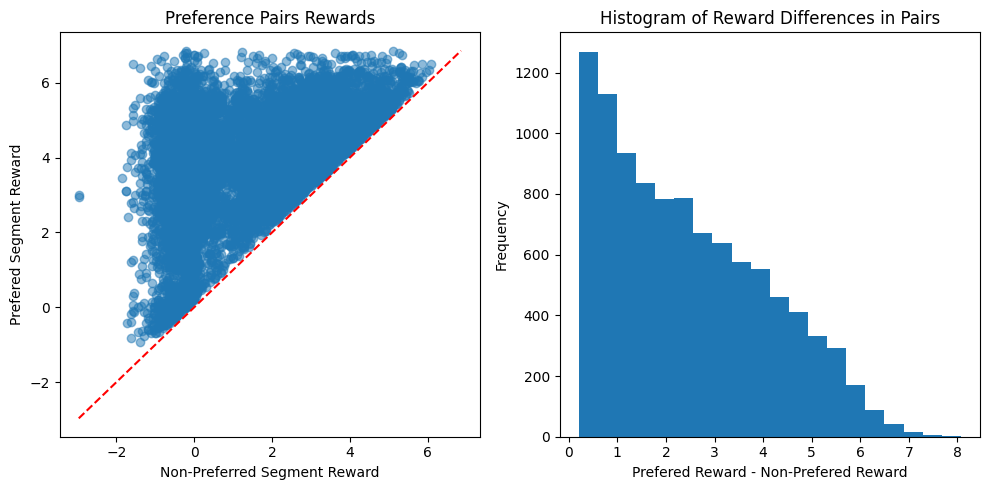

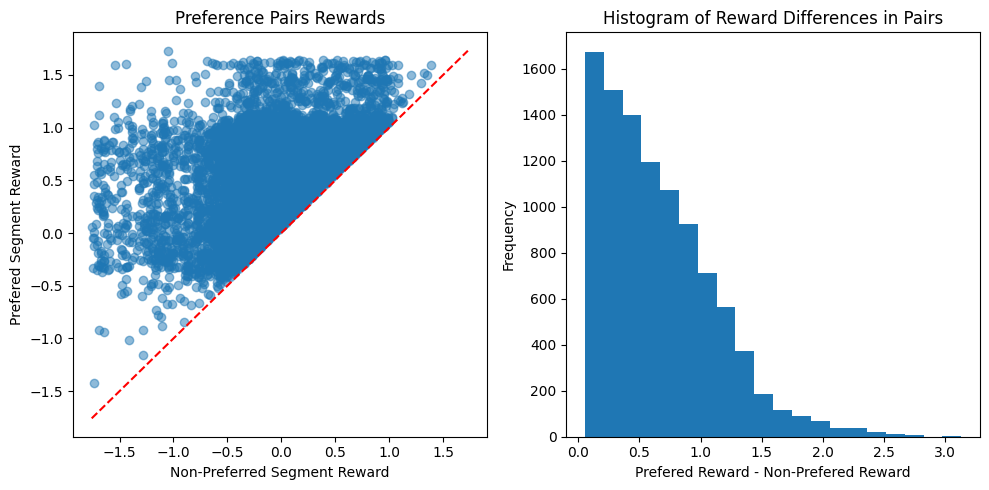

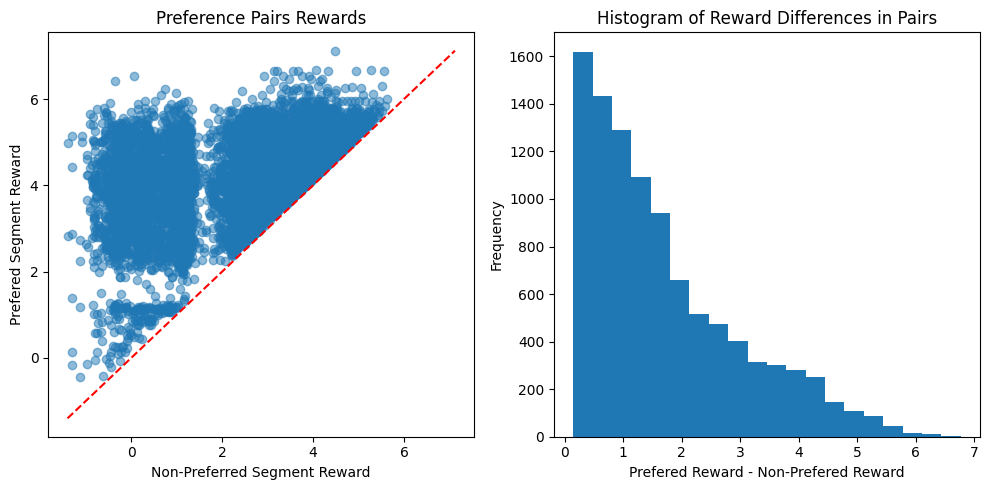

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute statistics env per env (due to memory constraints)
results = {}

for i, env in enumerate(environments):

    env_plot_data = plot_data[env]
    env_name = env if 'ALE' not in env else env.replace('/', '-')
    
    # 1. Preference Pairs Visualization
    plt.figure(figsize=(10, 5))
    cluster_rewards = np.array([desc[2] for desc in env_plot_data["description"]])

    # Extract pairs and their rewards
    pair_indices = np.array(env_plot_data["description_preference"])
    print(len(pair_indices))
    pair_rewards = cluster_rewards[pair_indices]

    # Scatter plot of pair rewards
    plt.subplot(121)
    plt.scatter(pair_rewards[:, 0], pair_rewards[:, 1], alpha=0.5)
    plt.plot([min(cluster_rewards), max(cluster_rewards)], [min(cluster_rewards), max(cluster_rewards)], 'r--')
    plt.xlabel("Non-Preferred Segment Reward")
    plt.ylabel("Prefered Segment Reward")
    plt.title("Preference Pairs Rewards")

    # Histogram of reward differences in pairs
    plt.subplot(122)
    pair_differences = pair_rewards[:, 1] - pair_rewards[:, 0]
    plt.hist(pair_differences, bins=20)
    plt.xlabel("Prefered Reward - Non-Prefered Reward")
    plt.ylabel("Frequency")
    plt.title("Histogram of Reward Differences in Pairs")

    plt.tight_layout()
    plt.savefig(f"{env_name}_description_pairs_analysis.png")